<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://erachelson.github.io/RLclass_MVA/">https://erachelson.github.io/RLclass_MVA/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Chapter 5: Policy gradient algorithms</div>

In this chapter we first depart from the (approximate) dynamic programming framework we have worked with so far. We turn back to a criterion for optimality we introduced in the first chapters, namely the average value of a policy across (starting) states. We explore the question of writing the gradient of this criterion with respect to policy parameters, which leads us to the very important policy gradient theorem and the family of policy gradient algorithms.

<div class="alert alert-success">

**Learning outcomes**   
By the end of this chapter, you should be able to:
- recall and explain the policy gradient theorem
</div>

# Policy gradient methods

<div class="alert alert-success">

**Bottomline question:**   
The previous chapters have focussed on *action-value methods*; they aimed at estimating $Q^*$ in order to deduce $\pi^*$, or they jointly optimized $Q$ and $\pi$. Could we directly optimize $\pi$?
</div>

Suppose we have a policy $\pi_\theta$ parameterized by a vector $\theta$. Our goal is to find the parameter $\theta^*$ corresponding to $\pi^*$.

Remarks:
- $\pi_\theta$ might not be able to represent $\pi^*$. We will take a shortcut and call $\pi^*$ the best policy among the $\pi_\theta$ ones.
- For discrete state and action spaces, the tabular policy representation is a special case of policy parameterization.
- Policy parameterization is a (possibly useful) way of introducing prior knowledge on the set of the desired policies.
- The optimal deterministic policies might not belong to the policy subspace of $\pi_\theta$, thus it makes sense to consider stochastic policies for $\pi_\theta$.
- It makes even more sense to consider stochastic policies that it opens the family of environments that we can tackle, like partially observable MDPs or multi-player games.

For stochastic policies, we shall write $\pi_\theta(a|s)$.

In the remainder of the chapter, we will assume that $\pi_\theta$ is differentiable with respect to $\theta$.

Suppose now we define some performance metric $J(\pi_\theta) = J(\theta)$. If $J$ is differentiable and a stochastic estimate $\tilde{\nabla}_\theta J(\theta)$ of the gradient is available, then we can define the stochastic gradient ascent update procedure:
$$\theta \leftarrow \theta + \alpha \tilde{\nabla}_\theta J(\theta).$$

We will call **policy gradient methods** all methods that follow such a procedure (whether or not they also learn a value function or not).

<div class="alert alert-success">

**Polcy gradient method**   
We call **policy gradient method** any method that performs stochastic gradient ascent on the policy's parameters.  
Given a stochastic estimate $\tilde{\nabla}_\theta J(\theta)$ of a policy's performance criterion with respect to the policy's parameters, such a method implements the update procedure: 
$$\theta \leftarrow \theta + \alpha \tilde{\nabla}_\theta J(\theta).$$
</div>

Remarks: 
- Note that $J$ is a generic criterion. For example, $J$ could be defined as the $\gamma$-discounted value of a starting state (or a distribution of starting states), or as the undiscounted reward over a certain horizon, or as the average reward.
- Note that this family of methods can use any gradient estimate for $\tilde{\nabla}_\theta J(\theta)$: formal calculus, finite differences, automated differentiation, evolution strategies, etc.
- Why is it interesting to look at policy gradient methods? Because there is no maximization step ($\max_a Q(s,a)$) during evaluation, which might be costly, especially for continuous actions, but only a call to $\pi_\theta(s)$ (or a draw from $\pi_\theta(a|s)$). This argument makes actor-critic architectures or direct policy search a method of choice for continuous actions domains (especially common in Robotics) and Policy Gradient is one of them.
- When do policy gradient approaches outperform value-based ones? It's hard to give a precise criterion; it really depends on the problem. One thing that comes into play is how easy it is to approximate the optimal policy or the optimal value function. If one is simpler than the other (by "simpler", we mean "it is easier to find a parameterization whose spanned function space almost includes the function to approximate"), then it is a good heuristic to try to approximate it. But this criterion might itself be hard to assess.

**Notations**

- We consider probability density functions $p(X)$ for all random variables $X$.
- For a policy $\pi_\theta$ and a random variable $X$ we write indifferently $p(X|\pi_\theta) = p(X|\theta)$.
- A trajectory is noted $\tau = (s_t,a_t)_{t\in \mathbb{N}}$.
- The state random variable at step $t$ is $S_t$ and its law's density is $p_t(s)$.
- The action random variable at step $t$ is $A_t$.

# The policy gradient theorem

## Reminder on the policy optimization objective

Recal the policy optimization objective defined in previous chapters, given a distribution $p_0$ on states:  
$$J(\pi) = \mathbb{E}_{s \sim p_0} \left[ V^{\pi} (s) \right].$$
Or equivalently:  
$$J(\pi) = \mathbb{E}_{(s_i,a_i)_{i \in \mathbb{N}}} \left[ \sum_{t=0}^\infty \gamma^t r(s_t,a_t)  | \pi, p_0 \right].$$
Since $p_0$ is supposed known and fixed, we will omit it in the rest of this chapter for the sake of readability.  
We can switch the sum and the expectation and get:  
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \mathbb{E}_{(s_i,a_i)_{i \in \mathbb{N}}} \left[ r(s_t,a_t)  | \pi \right].$$
But $\mathbb{E}_{(s_i,a_i)_{i \in \mathbb{N}}} \left[ r(s_t,a_t)  | \pi \right] = \mathbb{E}_{s_t,a_t} \left[ r(s_t,a_t)  | \pi \right]$. So:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \mathbb{E}_{s_t,a_t} \left[ r(s_t,a_t)  | \pi \right].$$
Now let's introduce the density of $(s_t,a_t)$:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \int_S \int_A r(s_t,a_t) p(s_t,a_t|\pi) ds_t da_t.$$
But $p(s_t,a_t|\pi) = p(s_t|\pi) p(a_t|s_t,\pi)$. By definition, $p(s_t|\pi) = p_t(s|\pi)$ and $p(a_t=a|s_t=s,\pi) = \pi(a|s)$. So:
$$J(\pi) = \sum_{t=0}^\infty \gamma^t \int_S \int_A r(s,a) p_t(s|\pi) \pi(a|s) ds da.$$
Let us isolate the terms that concern only states:
$$J(\pi) = \int_S \left[ \int_A r(s,a) \pi(a|s) da \right] \sum_{t=0}^\infty \gamma^t p_t(s|\pi) ds.$$
Let's note $\rho^\pi(s) = \sum_{t=0}^\infty \gamma^t p_t(s|\pi)$. We have encountered this quantity in previous chapters and called it the *state occupancy measure under policy $\pi$ and starting distribution $p_0$*. It is not a proper distribution per se (it sums to $\frac{1}{1-\gamma}$), and is sometimes also called the *improper state distribution under policy $\pi$* or the *improper state visitation frequency under policy $\pi$*. Then we have:
$$J(\pi) = \int_S \left[ \int_A r(s,a) \pi (a|s) da \right] \rho^\pi(s) ds.$$
And so finally, with a slight notation abuse because $\rho^\pi$ is not a probability distribution:
$$J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ r(s,a) \right].$$

In plain words, the value of a policy $\pi$ is the average value of the rewards when states are sampled according to $\rho^\pi$ and actions are sampled according to $\pi$.

## The policy gradient theorem

The crucial problem of computing $\nabla_\theta J(\theta)$ lies in the fact that when $\theta$ changes, both $\pi$ and $\rho^\pi$ change jointly. So there seems to be no straighforward way of evaluating this gradient. One could fall back to a *finite differences* approach to estimating this gradient, but this would require trying out a series of increments $\Delta \theta$ which quickly becomes impractical (because the increment size is hard to tune, especially in stochastic systems, and also because of the sample inefficiency of the approach).

Remark:
- Let's not discard finite difference methods too quickly. They have their merits and showed great successes through methods such as [PEGASUS (Ng and Jordan, 2000)](https://arxiv.org/abs/1301.3878). Also, having random $\Delta \theta$ drawn from a Gaussian distribution is essentially what Evolution Strategies do, and [Salimans et al. (2017)](https://arxiv.org/abs/1703.03864) or [Chrabaszcz et al. (2018)](https://arxiv.org/abs/1802.08842) illustrated how that could be a scalable method to obtain gradient estimates in RL. We won't cover these topics here and leave them as exercises.  

The key result of this chapter is that one can express the gradient of $J(\theta)$ as directly proportional to the value of $Q^\pi$ and the gradient of $\pi$:
<div class="alert alert-success">

**Policy gradient theorem:**  
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right]$$
</div>

<div class="alert alert-warning">

**Exercise:**  
Why is it not really a problem that $\rho^\pi$ is not a proper probability density function?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

It is not really a problem because it is still a measure, proportional to a density function.  
We are interested in ascent *directions*, not the exact gradient. The latter is proportional to the former. So as long as we can sample from a distribution whose mass is proportional to $\rho^\pi$, we obtain a correct direction estimate.
</details>

The proof of this result is simple but a bit tedious. We can however give the general intuition. Let's consider trajectories $\tau = (s_0,a_0,r_0,...)$ drawn according to $\pi$ from the starting state. Each of these trajectories has an overall payoff of $G(\tau) = \sum_t \gamma^t r_t$, and is drawn with probability density $p(\tau|\theta)$. Then the objective function can be written:
\begin{align}
J(\theta) &= \mathbb{E}_\tau \left[ G(\tau) | \theta \right]\\
 &= \int G(\tau) p(\tau | \theta) d\tau
\end{align}

So the objective function's gradient is:
\begin{align}
\nabla_\theta J(\theta) &= \nabla_\theta \int G(\tau) p(\tau|\theta) d\tau,\\
 &= \int G(\tau) \nabla_\theta p(\tau|\theta) d\tau,\\
 &= \int G(\tau) p(\tau|\theta) \frac{\nabla_\theta p(\tau|\theta)}{p(\tau|\theta)} d\tau,\\
 &= \mathbb{E}_\tau \left[ G(\tau) \nabla_\theta \log p(\tau|\theta) \right].
\end{align}

We have used the fact that $\nabla_\theta p(\tau|\theta) = p(\tau|\theta) \nabla_\theta \log p(\tau|\theta)$, sometimes known as the *nabla-log* trick.  
Let us study the $\nabla_\theta \log p(\tau|\theta)$ term along a series of remarks.

**Remark 1: law of $s_{t+1},a_{t+1}$ given the policy and history.**  
One has $p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) p(a_{t+1} | s_{t+1}, (s_i,a_i)_{i \in [0,t]}, \theta)$.  
But the transition model is Markovian, so $p(s_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | s_t, a_t)$.  
And the law of $a_{t+1}$ is given by the policy, so $p(a_{t+1} | s_{t+1}, (s_i,a_i)_{i \in [0,t]}, \theta) = \pi_\theta(a_{t+1}|s_{t+1})$.  
Consequently:
$$p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta) = p(s_{t+1} | s_t, a_t) \pi_\theta(a_{t+1}|s_{t+1}).$$

**Remark 2: probability density of a trajectory.**  
Recall that $p(\tau|\theta) = p((s_t,a_t)_{t\in [0,\infty]}|\theta)$.  
This joint probability can be decomposed into conditional probabilities: $$p(\tau|\theta) = p(s_0,a_0|\theta) \prod_{t=0}^\infty p(s_{t+1},a_{t+1} | (s_i,a_i)_{i \in [0,t]}, \theta).$$ 
The previous remarks allows us to simplify to: $$p(\tau|\theta) = p(s_0,a_0|\theta) \prod_{t=0}^\infty p(s_{t+1} | s_t, a_t) \pi_\theta(a_{t+1}|s_{t+1}).$$ 
By expanding the first term into $p(s_0)\pi_\theta(a_0|s_0)$ and reordering the terms inside the product, we obtain:
$$p(\tau|\theta) = p(s_0) \prod_{t=0}^\infty p(s_{t+1} | s_t, a_t) \pi_\theta(a_t|s_t).$$

**Remark 3: grad-log-prob of a trajectory.**  
Now let us consider the full $\nabla_\theta \log p(\tau|\theta)$ term. The previous remarks tell us that  
$$\nabla_\theta \log p(\tau|\theta) = \nabla_\theta \log p(s_0) + \sum_{t=0}^\infty \left[ \nabla_\theta \log p(s_{t+1} | s_t, a_t) + \nabla_\theta \log \pi_\theta(a_t|s_t)\right].$$
But the initial state distribution and the transition model do not depend on $\theta$, so this expression boils down to:
$$\nabla_\theta \log p(\tau|\theta) = \sum_{t=0}^\infty \nabla_\theta \log \pi_\theta(a_t|s_t).$$

And we will admit the step which leads to:
$$\nabla_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G(\tau) \nabla_\theta \log \pi_\theta(a|s) \right].$$

We don't quite have the policy gradient as stated above, but this intermediate result actually already provides us with a straightforward algorithm, so let's mark it:
<div class="alert alert-success">

**Policy gradient**  
Given trajectories $\tau=(s_t,a_t)_{t\in [0,\infty]}$ drawn according to policy $\pi$, and evaluated through a criterion $G(\tau)$, 
$$\nabla_\theta J(\theta) = \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G(\tau) \nabla_\theta \log \pi_\theta(a|s) \right].$$
</div>

So we could play policy $\pi_\theta$ from $p_0$, and collect pairs of states and actions $(s,a)$. After each trajectory terminates, sum the rewards obtained to get $G(\tau)$, then sum over all encountered states and actions the $G(\tau) \nabla_\theta \log \pi_\theta(a|s)$ terms. This yields an ascent direction: we can take a stochastic gradient ascent step, and repeat.

**Interpretation**  
Let us consider a fixed $s$.  
Then $\nabla_\theta \log \pi_\theta(a|s)$ is the answer to "in what direction should I change $\theta$ to increase the log probability of taking action $a$ in $s$?".  
The expression above tells us that in order to improve the value of $\pi_\theta$, we should change $\theta$ in a direction that is a linear combination of all $\nabla_\theta \pi_\theta(a|s)$, giving more weight to action $a$ in state $s$ in proportion to the value $G(\tau)$ of the trajectory they belong too.   
In even simpler words: if a trajectory was better than another, its action probabilities should be reinforced (hence the name of the algorithm).

The next section will focus on implementing this algorithm (almost), but for now let us finish deriving the policy gradient theorem.

**Remark 4: the expected grad-log-prob lemma.**  
Let us take a step aside and consider the expectation of $\nabla_\theta \log \pi_\theta(a|s)$.  
Let's simplify the notation and consider a generic probability density function $\pi_\theta(x)$. Then:
In a given $s$:
\begin{align}
\mathbb{E}_{a\sim \pi_\theta(s)} [ \nabla_\theta \log \pi_\theta(x) ] &= \int_A \pi_\theta(a|s) \nabla_\theta \log \pi_\theta(a|s) da\\
 &= \int_A \pi_\theta(a|s) da\\
 &= \nabla_\theta \int_A \pi_\theta(a|s) da\\
 &= \nabla_\theta 1\\
 &= 0
\end{align}
So we get that: 
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \nabla_\theta \log \pi_\theta(a|s) \right] = \mathbb{E}_{s\sim\rho^\pi} \left[ \mathbb{E}_{a\sim \pi} \left[ \nabla_\theta \log \pi_\theta(a|s) \right] \right] = \mathbb{E}_{s\sim\rho^\pi} [0]=  0.$$
Actually, we can generalize this immediately: we can multiply $\nabla_\theta \log \pi_\theta(a|s)$ by anything that does not depend on $a$ and obtain the same result:
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ b(s)\left[ \nabla_\theta \log \pi_\theta(a|s) \right] \right] = 0.$$
This will come in handy in a future section about baselines in policy gradients and will serve as a basis for the exercise on [Generalized Advantage Estimation (Schulman et al., 2016)](https://arxiv.org/abs/1506.02438), but for now it will help us finish proving the policy gradient theorem.

**Obtaining the policy gradient theorem**  
Recall that for a $\gamma$ discounted criterion:
$$G(\tau) = \sum_{t'=0}^\infty \gamma^{t'} r_{t'}.$$
Let us consider a given time step $t$, at which a certain $(s,a)$ is encountered in $\tau$. Then:
$$G(\tau) = \sum_{t'=0}^{t-1} \gamma^{t'} r_{t'} + \sum_{t'=t}^\infty \gamma^{t'} r_{t'}.$$
Then we have:
\begin{align*}
\nabla_\theta J(\theta) &= \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ G(\tau) \nabla_\theta \log \pi_\theta(a|s) \right],\\
 &= \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \left[\sum_{t'=0}^{t-1} \gamma^{t'} r_{t'} + \sum_{t'=t}^\infty \gamma^{t'} r_{t'} \right] \nabla_\theta \log \pi_\theta(a|s) \right].
\end{align*}
Since $t$ is the time of occurence of $(s,a)$ in $\tau$, the first sum $\sum_{t'=0}^{t-1} \gamma^{t'} r_{t'}$ does not depend on $a$. Consequently (thanks to the last remark):
$$\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \left[\sum_{t'=0}^{t-1} \gamma^{t'} r_{t'} \right] \nabla_\theta \log \pi_\theta(a|s) \right] = 0.$$

In other words, any reward obtained before action $a$ is taken should not participate in reinforcing the probability of $a$ in $s$. This seems rather intuitive: an action should be reinforced only based on its consequences, not on rewards acquired before taking the action.

So, since $Q^\pi(s,a) = \mathbb{E} [ \sum_{t'=t}^\infty \gamma^{t'} r_{t'} | S_t=s, A_t=a, \theta]$, we finally obtain the policy gradient:
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right].$$

**Interpretation**  
Let us rephrase and refine the previous interpretation.  
Consider a fixed $s$. Then (again) $\nabla_\theta \log \pi(a|s)$ is the answer to "in what direction should I change $\theta$ to increase the log probability of taking action $a$ in $s$?".   
The policy gradient theorem tells us that in order to improve the value of $\pi_\theta$, we should change $\theta$ in a direction that is a linear combination of all $\nabla_\theta \pi(a|s)$, giving more weight to actions that provide a large $Q^\pi(s,a)$. 

We can push the interpretation of $\nabla_\theta \log \pi(a|s) = \frac{\nabla_\theta \pi(a|s)}{\pi(a|s)}$ a bit further. $\nabla_\theta \pi(a_t|s_t)$ is a vector in parameter space that points in the direction of greatest increase of $\pi(a|s)$. The update will encourage taking a step in this direction if the action provided high return (through $Q(s,a)$), but moving in this direction will be moderated if the action is already picked frequently (through $\pi(a|s)$) so that other actions have a chance also.

# REINFORCE

Recall the policy gradient theorem:
<div class="alert alert-success">

**Policy gradient**  
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ Q^\pi(s,a) \nabla_\theta \log\pi(a|s)\right]$$
</div>

So, to compute the gradient, we can run the policy within the environment, and this will provide us with states distributed according to $\rho^\pi$ and actions distributed according to $\pi$. The full trajectory of states-actions-rewards provides a Monte Carlo estimate $G_t$ of $Q^\pi(s_t,a_t)$ from any state $s_t$ traversed by the trajectory. In turn, this allows to estimate $Q^\pi(s_t,a_t) \nabla_\theta \log \pi(a_t|s_t)$ for any of these states. The sum over all states provides the gradient estimate.

This algorithm, introduced by [Williams (1992)](https://link.springer.com/article/10.1007/BF00992696) is called REINFORCE. It requires a finite-length trajectory and its pseudo-code goes as follows.
1. Initialize policy parameter $\theta$
2. Generate a trajectory by playing $\pi$: $s_0,a_0,r_0,...s_{T}$
3. For $t\in [1, 2, … , T]$:
    1. Estimate return $G_t$
    2. Update policy parameter: $\theta \leftarrow \theta + \alpha \gamma^t G_t \nabla_\theta \log \pi(a_t|s_t)$

Modern deep learning libraries don't take gradients as inputs. Instead, they use automated differentiation to compute them for a given expression, given a batch of samples. So we would like to build an objective function such that its gradient estimated on the minibatch composed of the last trajectory's samples $(s,a)$ corresponds to the expression above.

So we want to define $\ell(\theta)$ such that $-\nabla_\theta \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \ell(\theta,s,a) \right]$ coincides with $\nabla_\theta J(\theta)$. Note that, computationally, the $G_t$ terms are just coefficients in the gradient estimate. So, very simply, taking $\ell(\theta) = Q(s,a)\cdot \nabla_\theta \log \pi(a|s)$ achieves this goal as long as $Q(s,a)$ is an unbiased estimate of $Q^\pi(s,a)$. 

**Super important remark**  
In supervised learning, it is a common practice to monitor the empirical risk along training. 
But $L(\theta) = -\mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \ell(\theta,s,a) \right]$ is not comparable to the losses one usually encounters in supervised learning in any way!  
In particular, $-L(\theta) \neq J(\theta)$. So it makes absolutely no sense monitoring the value of this artificial "loss" function along training, and even less interpreting its value as some performance metric. It is *just* an expression whose gradient coincides with the (opposite of the) policy gradient.

Let's implement REINFORCE for discrete action spaces.
<div class="alert alert-warning">
    
**Exercise:**  
Declare a neural networks approximator for a categorical distribution for $\pi(a|s)$.  
The `forward` method should output action probabilities.  
Define a `sample_action` method that draws from the actions probabilities in state $s$.  
Define a `log_prob` method that returns the log probability of an $(s,a)$ pair.
</div>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class policyNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        n_action = env.action_space.n
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, n_action)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(dim=0)
        x = F.relu(self.fc1(x))
        action_scores = self.fc2(x)
        return F.softmax(action_scores,dim=1)

    def sample_action(self, x):
        probabilities = self.forward(x)
        action_distribution = Categorical(probabilities)
        return action_distribution.sample().item()

    def log_prob(self, x, a):
        probabilities = self.forward(x)
        action_distribution = Categorical(probabilities)
        return action_distribution.log_prob(a)

<div class="alert alert-warning">
    
**Exercise:**  
Define a class that implements REINFORCE. Instead of drawing a single trajectory as in the pseudo-code above, include an option to draw several trajectories with the same policy. This will better reflect $\rho^\pi$ and provide less noisy gradients.
</div>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

class reinforce_agent:
    def __init__(self, config, policy_network):
        self.device = "cuda" if next(policy_network.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(policy_network.parameters()).dtype
        self.policy = policy_network
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.99
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = torch.optim.Adam(list(self.policy.parameters()),lr=lr)
        self.nb_episodes = config['nb_episodes'] if 'nb_episodes' in config.keys() else 1
    
    def one_gradient_step(self, env):
        # run trajectories until done
        episodes_sum_of_rewards = []
        states = []
        actions = []
        returns = []
        for ep in range(self.nb_episodes):
            x,_ = env.reset()
            rewards = []
            episode_cum_reward = 0
            while(True):
                a = self.policy.sample_action(torch.as_tensor(x))
                y,r,d,_,_ = env.step(a)
                states.append(x)
                actions.append(a)
                rewards.append(r)
                episode_cum_reward += r
                x=y
                if d:
                    # compute returns-to-go
                    new_returns = []
                    G_t = 0
                    for r in reversed(rewards):
                        G_t = r + self.gamma * G_t
                        new_returns.append(G_t)
                    new_returns = list(reversed(new_returns))
                    returns.extend(new_returns)
                    episodes_sum_of_rewards.append(episode_cum_reward)
                    break
        # make loss
        returns = torch.tensor(returns)
        log_prob = self.policy.log_prob(torch.as_tensor(np.array(states)),torch.as_tensor(np.array(actions)))
        loss = -(returns * log_prob).mean()
        # gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return np.mean(episodes_sum_of_rewards)

    def train(self, env, nb_rollouts):
        avg_sum_rewards = []
        for ep in trange(nb_rollouts):
            avg_sum_rewards.append(self.one_gradient_step(env))
        return avg_sum_rewards

<div class="alert alert-warning">
    
**Exercise:**  
Run your agent for 50 gradient steps on `CartPole-v1`, drawing 10 episodes at each step.  
Experiment with another number of episodes and vary the gradient step size.
</div>

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


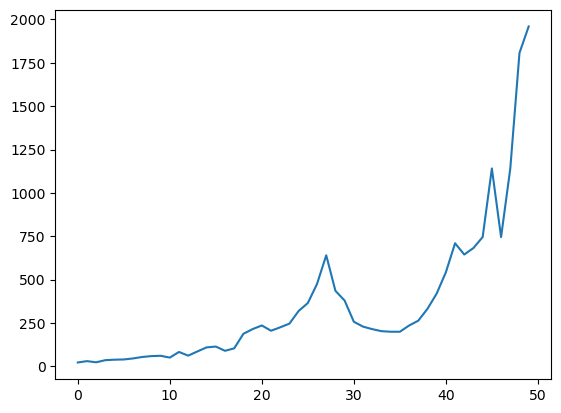

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt

#env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = gym.make('CartPole-v1', render_mode="rgb_array")
config = {'gamma': .99,
          'learning_rate': 0.01,
          'nb_episodes': 10
         }

pi = policyNetwork(env)
agent = reinforce_agent(config, pi)
returns = agent.train(env,50)
plt.plot(returns)

In [4]:
import gymnasium as gym
from gymnasium.utils.save_video import save_video

#test_env = gym.make("LunarLander-v2", render_mode="rgb_array_list")
test_env = gym.make("CartPole-v1", render_mode="rgb_array_list")
s,_ = test_env.reset()
with torch.no_grad():
    for t in range(1000):
        a = pi.sample_action(torch.as_tensor(s))
        s2,r,d,trunc,_ = test_env.step(a)
        s = s2
        if d:
            break

save_video(test_env.render(), "videos", fps=test_env.metadata["render_fps"], name_prefix="reinforce_policy")

Moviepy - Building video /home/emmanuel/git_repos/RLclass_MVA/notebooks/videos/reinforce_policy-episode-0.mp4.
Moviepy - Writing video /home/emmanuel/git_repos/RLclass_MVA/notebooks/videos/reinforce_policy-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/emmanuel/git_repos/RLclass_MVA/notebooks/videos/reinforce_policy-episode-0.mp4


In [5]:
from IPython.display import Video
Video("videos/reinforce_policy-episode-0.mp4")

<div class="alert alert-warning">
    
**Exercise:**  
The code above is slightly inefficient as it passes each state through the network twice: one when drawing the action (`sample_action`), the other when computing log probabilities (`log_prob`). Make this a bit more efficient by writing a `sample_action_and_log_prob` function in the `reinforce_agent` class, which jointly draws the action and computes its log probability, enabling storing the log probabilities along training.
</div>

In [ ]:
#%load solutions/no_solution_yet.py

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

class reinforce_agent:
    def __init__(self, config, policy_network):
        self.device = "cuda" if next(policy_network.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(policy_network.parameters()).dtype
        self.policy = policy_network
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.99
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = torch.optim.Adam(list(self.policy.parameters()),lr=lr)
        self.nb_episodes = config['nb_episodes'] if 'nb_episodes' in config.keys() else 1

    def sample_action_and_log_prob(self, x):
        probabilities = self.policy(torch.as_tensor(x))
        action_distribution = Categorical(probabilities)
        action = action_distribution.sample()
        log_prob = action_distribution.log_prob(action)
        return action.item(), log_prob
    
    def one_gradient_step(self, env):
        # run trajectories until done
        episodes_sum_of_rewards = []
        log_probs = []
        returns = []
        for ep in range(self.nb_episodes):
            x,_ = env.reset()
            rewards = []
            episode_cum_reward = 0
            while(True):
                a, log_prob = self.sample_action_and_log_prob(x)
                y,r,d,_,_ = env.step(a)
                log_probs.append(log_prob)
                rewards.append(r)
                episode_cum_reward += r
                x=y
                if d:
                    # compute returns-to-go
                    new_returns = []
                    G_t = 0
                    for r in reversed(rewards):
                        G_t = r + self.gamma * G_t
                        new_returns.append(G_t)
                    new_returns = list(reversed(new_returns))
                    returns.extend(new_returns)
                    episodes_sum_of_rewards.append(episode_cum_reward)
                    break
        # make loss
        returns = torch.tensor(returns)
        log_probs = torch.stack(log_probs)
        loss = -(returns * log_probs).mean()
        # gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return np.mean(episodes_sum_of_rewards)

    def train(self, env, nb_rollouts):
        avg_sum_rewards = []
        for ep in trange(nb_rollouts):
            avg_sum_rewards.append(self.one_gradient_step(env))
        return avg_sum_rewards

100%|██████████| 50/50 [00:02<00:00, 21.98it/s]


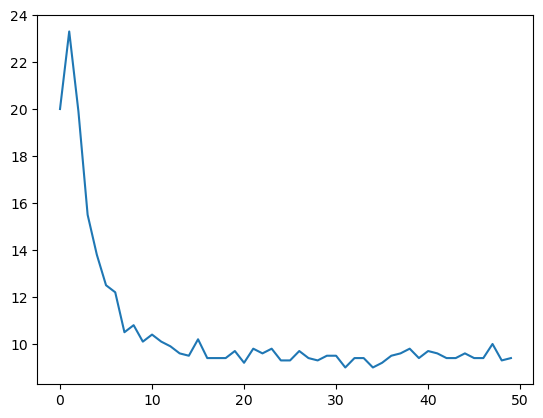

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt

#env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = gym.make('CartPole-v1', render_mode="rgb_array")
config = {'gamma': .99,
          'learning_rate': 0.01,
          'nb_episodes': 10
         }

pi = policyNetwork(env)
agent = reinforce_agent(config, pi)
returns = agent.train(env,50)
plt.plot(returns)

One key feature of policy gradient algorithms is that they are on-policy: they require the data to have been collected by the current policy, and discard this data once a gradient step is taken. Although this might seem sample inefficient, it can turn out to be an acceptable compromise if the policy gradient steps take the policy towards good returns quickly enough.

A direct consequence of this on-policy property, is that policy gradients don't use experience replay buffers. Instead, they can take advantage of parallel computation to collect samples. We saw that running several rollouts with the same policy greatly helped in reducing the gradient's variance.

<div class="alert alert-warning">
    
**Exercise:**  
Gymnasium provides a [vectorized environments](https://gymnasium.farama.org/api/vector/) class, which enables running multiple independent copies of the same environment in parallel. Modify the previous code to use these environments.
</div>

In [ ]:
import gymnasium as gym

## Make vector env
#envs = gym.vector.make("CartPole-v1", num_envs=3)
envs = gym.make_vec("CartPole-v1", num_envs=10)
## Reset all environments
states, _ = envs.reset(seed=42)
#print(states)
## Choose actions
actions = envs.action_space.sample()
#print(actions)
## Step
observations, rewards, termination, truncation, infos = envs.step(actions)
#print(observations)
#print(infos)

for t in range(50):
    actions = envs.action_space.sample()
    observations, rewards, termination, truncation, infos = envs.step(actions)
    if not infos=={}:
        print("step", t)
        print("observations\n", observations)
        print("termination", termination)
        print("truncation", truncation)
        print("infos\n", infos)
        break
    

# Actor-critic algorithms and baselines in policy gradients

**Actor-critic algorithms**  
Suppose now that we don't want a Monte Carlo estimate of $Q^\pi(s,a)$ in the Policy Gradient theorem, and are rather willing to store a function approximator $Q_w$ for $Q^\pi(s,a)$. This leads us to store both a policy $\pi_\theta$ and a value function $Q_w$. The value function *criticizes* the policy's selected actions by assigning numerical values to them, hence the names of *critic* and *actor*. So actor-critic algorithms are policy gradient algorithms that use an actor-critic architecture (remember: the opposite is not necessarily true).

The $Q_w$ function of the critic can be learned as a risk minimization problem (eg. a least squares fitting problem), using temporal differences. Note that although this learning is off-policy, the data collection for the application of the policy gradient theorem still requires on-policy data.

<div class="alert alert-warning">
    
**Exercise:**  
Write the pseudo code of a policy gradient algorithm which estimates a parametric approximator $Q_w$ of $Q^\pi$ using TD(0).
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Ready to see the answer? (click to expand)</b></summary>

TODO
</details>

**Baslines in policy gradients**  
Using estimators of $Q^\pi$ in the application of the policy gradient theorem yields gradient estimates which often have a high variance. Following the expected grad-log-prob lemma, a common practice consists in substracting an action-independent *baseline* $b(s)$ from the estimate of $Q^\pi(s,a)$, yielding:
$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\substack{s\sim\rho^\pi \\ a\sim \pi}} \left[ \left( Q^\pi(s,a) -b(s) \right) \nabla_\theta \log\pi(a|s)\right].$$

It is rather easy to remark that this baseline does not affect the gradient estimate since it's expected value is zero (thanks to the expected grad-log-prob lemma). However it can contribute to strongly decrease the estimate's variance. One common choice for such a baseline is the policy's value function $V^\pi$. This introduces an *advantage* estimation problem within policy gradient algorithms, where the advantage is the function defined as:
$$A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s).$$

Remark that the temporal difference at each time step $\delta = r + \gamma V^\pi(s') - V^\pi(s)$ is an estimate of the advantage $A^\pi(s,a)$. Using this remark, a simple one-step Actor-Critic method based on TD(0) and a value function $V_w$ goes as follows:
1. In $s$, draw $a \sim \pi$
2. Observe $r, s'$
3. Compute $\delta = r + \gamma V_w(s') - V_w(s)$
4. Update critic's parameters (TD(0) step) $w \leftarrow w + \alpha \delta \nabla_w V_w(s)$
5. Update actor's parameters (policy gradient theorem) $\theta \leftarrow \theta + \alpha \delta \nabla_\theta \log \pi(a|s)$
6. $s\leftarrow s'$ and repeat

# A2C

# TRPO

# Homework

## REINFORCE on continuous action domains

## Policy gradients for the finite horizon criterion

Derive the PG for the total reward, finite horizon criterion.

Implement a REINFORCE algorithm (maybe more? an AC algorithm?)

## Generalized advantage estimation

## PPO

## Gradient-free policy search

OpenAI ES and Canonical ES